In [1]:
import numpy as np
from scipy import ndimage
from scipy.ndimage import convolve
from scipy.ndimage import gaussian_filter,sobel
from scipy import misc
from PIL import Image


In [2]:
import cv2
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg

In [3]:
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

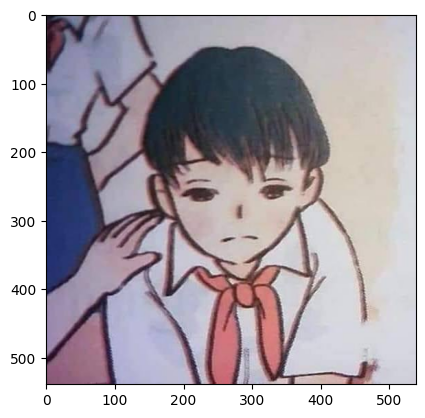

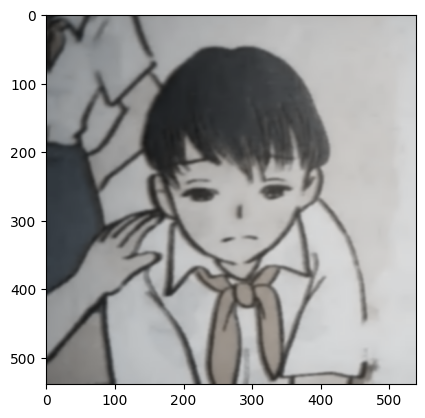

In [4]:
#Ví dụ
imgs = Image.open(r"D:\\project_CTV\\avatar.jpg")
plt.imshow(imgs)
plt.show()
data_img = np.array(imgs)
data_img1 = gaussian_filter(data_img,sigma=1)
data_img1 = gaussian_filter(data_img1,sigma=1)
data_img1 = gaussian_filter(data_img1,sigma=1)
plt.imshow(data_img1)
plt.show()

Tính toán độ xám 

In [5]:
def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = ndimage.filters.convolve(img, Kx)
    Iy = ndimage.filters.convolve(img, Ky)
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    #G là ảnh được lưu dưới dạng ma trận sau khi nhân tích chập, còn theta là số đo góc của mỗi pixel
    return (G, theta)


In [6]:
import numpy as np
from scipy import ndimage

(640, 960, 3)


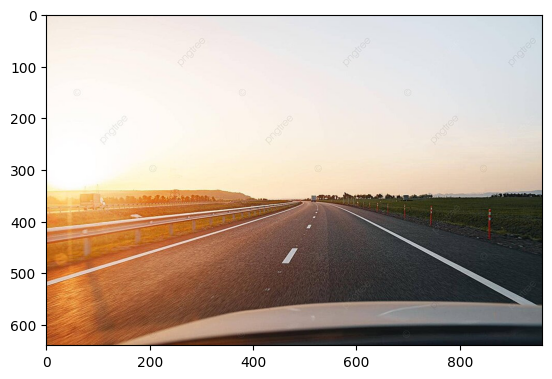

(640, 960)


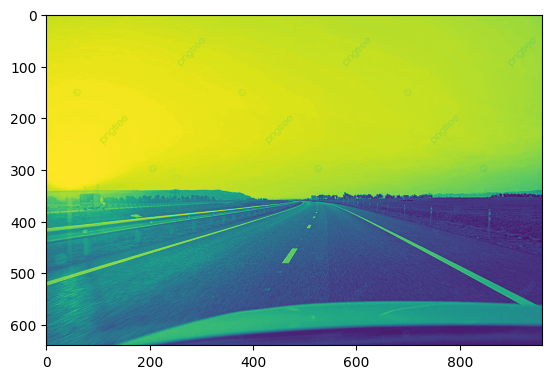

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_14528\2559970681.py:9: DeprecationWarning: Please import `convolve` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  Ix = ndimage.filters.convolve(img, Kx)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_14528\2559970681.py:10: DeprecationWarning: Please import `convolve` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  Iy = ndimage.filters.convolve(img, Ky)


(640, 960)


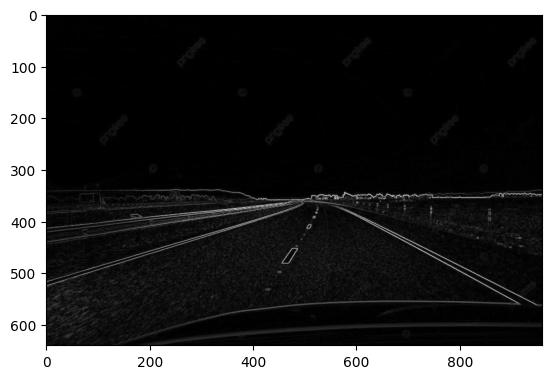

In [7]:
import scipy
from PIL import Image
import numpy as np
img = mpimg.imread(r"..\\road1.jpg")
print(img.shape)
plt.imshow(img)
plt.show()
img = img.mean(axis=2)
print(img.shape)
plt.imshow(img)
plt.show()
new_img, theta = sobel_filters(img)
print(new_img.shape)
plt.imshow(new_img, cmap='gray')
plt.show()


In [8]:
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180
    for i in range(1,M-1):
        for j in range(1,N-1):
            # Trục x là các điểm i (trục dọc)
            # Trục y là các điểm j (trục ngang)
            # Tạo ma trận kề [i-1,j-1 | i-1,j | i-1,j+1]
            #                [ i ,j-1 |  i,j  |  i,j+1]
            #                [i+1,j-1 | i+1,j | i+1,j+1]
            # với (i,j) là trọng tâm
            try:
                q = 255
                r = 255                
                # Góc 0 độ: Di chuyển theo hướng ngang (x) hoặc chéo dọc (y)
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1] # Pixel bên phải
                    r = img[i, j-1] # Pixel bên trái
                # Góc 45 độ: Di chuyển từ trên phải xuống dưới trái
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i-1, j+1] # Pixel trên phải
                    r = img[i+1, j-1] # Pixel dưới trái
                # Góc 90 độ: Di chuyển theo hướng dọc (y)
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i-1, j] # Pixel trên
                    r = img[i+1, j] # Pixel dưới
                # Góc 135 độ: Di chuyển từ trên trái xuống dưới phải
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1] # Pixel trên trái
                    r = img[i+1, j+1] # Pixel dưới phải

                if (img[i,j] >= q) and (img[i,j] >= r): 
                    # Nếu giá trị gradient của pixel hiện tại (img[i,j]) lớn hơn hoặc bằng cả hai giá trị 
                    # gradient của các pixel lân cận theo các hướng đã xác định (q và r)
                    # thì pixel đó được coi là một điểm cực đại địa phương
                    # =>giá trị của pixel trong ma trận kết quả (Z[i,j]) được thiết lập bằng giá trị gradient của pixel hiện tại.
                    Z[i,j] = img[i,j]
                else:
                    # Ngược lại
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z


In [9]:
#Hàm tối ưu
def non_max_suppression_optimized(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    # Tinh chỉnh giá trị của các ngưỡng hướng
    angle_mask_right = (angle <= 22.5) | (angle > 157.5)
    angle_mask_top_right = (angle > 22.5) & (angle <= 67.5)
    angle_mask_top = (angle > 67.5) & (angle <= 112.5)
    angle_mask_top_left = (angle > 112.5) & (angle <= 157.5)

    # So sánh với các hàng xóm theo hướng cụ thể và áp dụng tinh chỉnh ngưỡng
    left_right = (img > np.roll(img, 1, axis=1)) & (img > np.roll(img, -1, axis=1))
    top_bottom = (img > np.roll(img, 1, axis=0)) & (img > np.roll(img, -1, axis=0))
    diag1 = (img > np.roll(np.roll(img, -1, axis=0), 1, axis=1)) & (img > np.roll(np.roll(img, 1, axis=0), -1, axis=1))
    diag2 = (img > np.roll(np.roll(img, 1, axis=0), 1, axis=1)) & (img > np.roll(np.roll(img, -1, axis=0), -1, axis=1))

    # Kết hợp các điều kiện để xác định cạnh
    Z[(angle_mask_right & left_right) | 
      (angle_mask_top & top_bottom) | 
      (angle_mask_top_right & diag1) | 
      (angle_mask_top_left & diag2)] = img[(angle_mask_right & left_right) | 
                                            (angle_mask_top & top_bottom) | 
                                            (angle_mask_top_right & diag1) | 
                                            (angle_mask_top_left & diag2)]

    return Z


<function matplotlib.pyplot.show(close=None, block=None)>

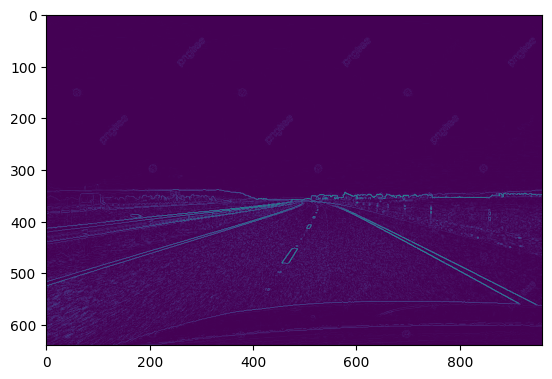

In [10]:
img_non_max = non_max_suppression_optimized(new_img,theta)
# print(img_non_max.max())
plt.imshow(img_non_max)
plt.show

In [11]:
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.25):
    
    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)

In [12]:
def hysteresis(img, weak, strong=255):
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

Model(Mô hình)

In [13]:
class EdgeDetector:
    def __init__(self, imgs, sigma=1, kernel_size=1, weak_pixel=1, strong_pixel=1, lowthreshold=1, highthreshold=1):
        self.imgs = imgs
        self.imgs_final = []
        self.img_smoothed = None
        self.gradientMat = None
        self.thetaMat = None
        self.nonMaxImg = None
        self.thresholdImg = None
        self.weak_pixel = weak_pixel
        self.strong_pixel = strong_pixel
        self.sigma = sigma
        self.kernel_size = kernel_size
        self.lowThreshold = lowthreshold
        self.highThreshold = highthreshold
    
    def gaussian_kernel(self, size, sigma=1):
        size = int(size) // 2
        x, y = np.mgrid[-size:size+1, -size:size+1]
        normal = 1 / (2.0 * np.pi * sigma**2)
        g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
        return g
    
    def sobel_filters(self,img):
        Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
        Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
        Ix = ndimage.convolve(img, Kx)
        Iy = ndimage.convolve(img, Ky)
        G = np.hypot(Ix, Iy)
        G = G / G.max() * 255
        theta = np.arctan2(Iy, Ix)
        return (G, theta)

    def non_max_suppression_optimized(self,img, D):
        M, N = img.shape
        Z = np.zeros((M,N), dtype=np.int32)
        angle = D * 180. / np.pi
        angle[angle < 0] += 180

        # Tinh chỉnh giá trị của các ngưỡng hướng
        angle_mask_right = (angle <= 22.5) | (angle > 157.5)
        angle_mask_top_right = (angle > 22.5) & (angle <= 67.5)
        angle_mask_top = (angle > 67.5) & (angle <= 112.5)
        angle_mask_top_left = (angle > 112.5) & (angle <= 157.5)

        # So sánh với các hàng xóm theo hướng cụ thể và áp dụng tinh chỉnh ngưỡng
        left_right = (img > np.roll(img, 1, axis=1)) & (img > np.roll(img, -1, axis=1))
        top_bottom = (img > np.roll(img, 1, axis=0)) & (img > np.roll(img, -1, axis=0))
        diag1 = (img > np.roll(np.roll(img, -1, axis=0), 1, axis=1)) & (img > np.roll(np.roll(img, 1, axis=0), -1, axis=1))
        diag2 = (img > np.roll(np.roll(img, 1, axis=0), 1, axis=1)) & (img > np.roll(np.roll(img, -1, axis=0), -1, axis=1))

        # Kết hợp các điều kiện để xác định cạnh
        Z[(angle_mask_right & left_right) | 
        (angle_mask_top & top_bottom) | 
        (angle_mask_top_right & diag1) | 
        (angle_mask_top_left & diag2)] = img[(angle_mask_right & left_right) | 
                                                (angle_mask_top & top_bottom) | 
                                                (angle_mask_top_right & diag1) | 
                                                (angle_mask_top_left & diag2)]
        return Z

    def non_max_suppression(self,img, D):
        M, N = img.shape
        Z = np.zeros((M,N), dtype=np.int32)
        angle = D * 180. / np.pi
        angle[angle < 0] += 180
        for i in range(1,M-1):
            for j in range(1,N-1):
                try:
                    q = 255
                    r = 255
                    if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                        q = img[i, j+1] # Pixel bên phải
                        r = img[i, j-1] # Pixel bên trái
                    elif (22.5 <= angle[i,j] < 67.5):
                        q = img[i-1, j+1] # Pixel trên phải
                        r = img[i+1, j-1] # Pixel dưới trái
                    elif (67.5 <= angle[i,j] < 112.5):
                        q = img[i-1, j] # Pixel trên
                        r = img[i+1, j] # Pixel dưới
                    elif (112.5 <= angle[i,j] < 157.5):
                        q = img[i-1, j-1] # Pixel trên trái
                        r = img[i+1, j+1] # Pixel dưới phải
                    if (img[i,j] >= q) and (img[i,j] >= r): 
                        Z[i,j] = img[i,j]
                    else:
                        Z[i,j] = 0
                except IndexError as e:
                    pass 
        return Z

    def threshold(self, img):
        highThreshold = img.max() * self.highThreshold;
        lowThreshold = highThreshold * self.lowThreshold;
        M, N = img.shape
        res = np.zeros((M,N), dtype=np.int32)
        weak = np.int32(self.weak_pixel)
        strong = np.int32(self.strong_pixel)
        strong_i, strong_j = np.where(img >= highThreshold)
        weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
        res[strong_i, strong_j] = strong
        res[weak_i, weak_j] = weak
        return (res)
    
    def hysteresis_optimize(self,img, low_threshold, high_threshold):
        M, N = img.shape
        strong_edges = (img > high_threshold)
        weak_edges = ((img >= low_threshold) & (img <= high_threshold))

        Z = np.zeros((M,N), dtype=np.int32)
        Z[strong_edges] = img[strong_edges]

        while np.any(weak_edges):
            # Find the weak edges next to strong edges
            new_strong_edges = (weak_edges & (np.roll(strong_edges, 1, axis=0) | 
                                            np.roll(strong_edges, -1, axis=0) | 
                                            np.roll(strong_edges, 1, axis=1) | 
                                            np.roll(strong_edges, -1, axis=1) |
                                            np.roll(np.roll(strong_edges, 1, axis=0), 1, axis=1) |
                                            np.roll(np.roll(strong_edges, 1, axis=0), -1, axis=1) |
                                            np.roll(np.roll(strong_edges, -1, axis=0), 1, axis=1) |
                                            np.roll(np.roll(strong_edges, -1, axis=0), -1, axis=1)))
            strong_edges[new_strong_edges] = True
            Z[new_strong_edges] = img[new_strong_edges]
            weak_edges[new_strong_edges] = False
        return Z

    def hysteresis(self, img):
        M, N = img.shape
        weak = self.weak_pixel
        strong = self.strong_pixel

        for i in range(1, M-1):
            for j in range(1, N-1):
                if (img[i,j] == weak):
                    try:
                        if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                            or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                            or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                            img[i, j] = strong
                        else:
                            img[i, j] = 0
                    except IndexError as e:
                        pass
        return img
    
    def detect(self):
        self.imgs_final = []
        for img in self.imgs:
            img_array = np.array(img)         
            self.img_smoothed = gaussian_filter(img_array, sigma=self.sigma)     
            self.gradientMat, self.thetaMat = self.sobel_filters(self.img_smoothed)
            self.nonMaxImg = self.non_max_suppression_optimized(self.gradientMat, self.thetaMat)           
            self.thresholdImg = self.threshold(self.nonMaxImg)
            # img_final = self.hysteresis(self.thresholdImg)
            img_final = self.hysteresis_optimize(self.thresholdImg,self.lowThreshold,self.highThreshold)
            self.imgs_final.append(img_final)
        return self.imgs_final

In [14]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.15989 * r + 0.9870 * g + 0.00140 * b
    return gray

In [15]:
imgs = mpimg.imread(r"D:\\project_CTV\\road2.jpg")
imgs = imgs.mean(axis=2)
print(imgs.shape)
# plt.imshow(imgs)
# plt.show()

(640, 960)


sigma: Sigma được sử dụng trong quá trình làm mờ Gaussian để kiểm soát mức độ làm mờ. Giá trị sigma cao hơn dẫn đến việc làm mờ nhiều hơn, giúp giảm nhiễu trong ảnh trước khi thực hiện phát hiện cạnh. Lựa chọn sigma ảnh hưởng đến độ nhạy của việc phát hiện cạnh đối với các chi tiết nhỏ so với các cạnh rộng lớn.

kernel_size: Tham số này chỉ định kích thước của kernel được sử dụng cho làm mờ Gaussian và bộ lọc Sobel. Kích thước kernel lớn hơn có thể dẫn đến việc làm mờ hoặc làm mịn nhiều hơn, ảnh hưởng đến việc phát hiện cạnh mảnh so với cạnh rộng. Kích thước kernel phải là số lẻ và thường nằm trong khoảng từ 3 đến 7 hoặc nhiều hơn, tùy thuộc vào mức độ chi tiết mong muốn.

weak_pixel: Trong quá trình ngưỡng, giá trị này đại diện cho cường độ được gán cho các cạnh yếu. Các cạnh yếu là những cạnh không nổi bật nhưng có thể vẫn là một phần của cạnh. Lựa chọn giá trị này có thể ảnh hưởng đến khả năng của thuật toán trong việc bảo tồn hoặc loại bỏ các cạnh yếu trong bước hysteresis.

strong_pixel: Giá trị này đại diện cho cường độ được gán cho các cạnh mạnh, có khả năng cao là cạnh thực sự trong ảnh. Đặt giá trị cao hơn giúp phân biệt rõ ràng cạnh mạnh với cạnh yếu và không phải cạnh.

lowthreshold: Tham số này định nghĩa ngưỡng dưới cho bước ngưỡng. Đây là một phần của cường độ tối đa trong ảnh gradient và giúp xác định các cạnh yếu. Giảm ngưỡng này có thể dẫn đến việc phát hiện nhiều cạnh hơn, bao gồm cả nhiễu, trong khi tăng nó có thể bỏ sót các chi tiết mảnh.

highthreshold: Tương tự như lowthreshold, nhưng nó thiết lập ngưỡng trên cho việc ngưỡng. Các cạnh có cường độ cao hơn ngưỡng này được coi là cạnh mạnh. Tham số này quan trọng trong việc xác định những cạnh nào đủ nổi bật để được giữ lại trong kết quả phát hiện cạnh cuối cùng.

In [16]:
detector = EdgeDetector([imgs], sigma=1.5, kernel_size=3, lowthreshold=0.07, highthreshold=0.30, weak_pixel=10,strong_pixel=2000)
imgs_final = detector.detect()


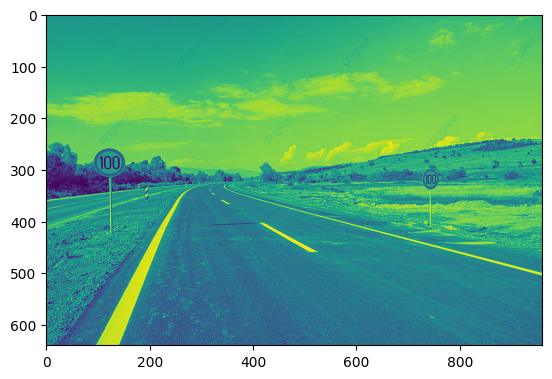

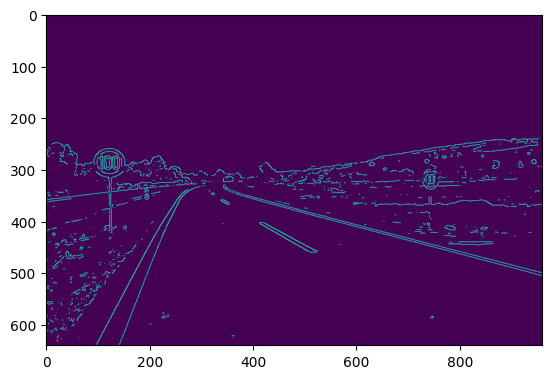

In [17]:
plt.imshow(imgs)
plt.show()
plt.imshow(imgs_final[0])
plt.show()

Dưới đây mình sử dụng thuần thư viện CV2

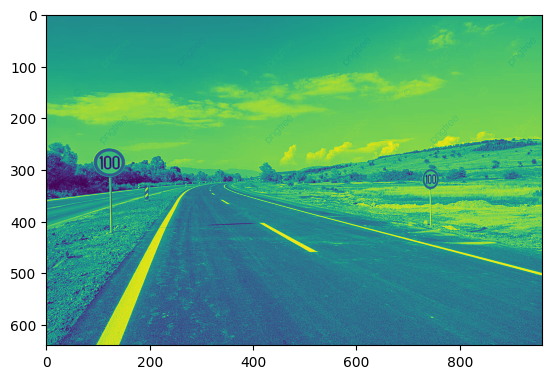

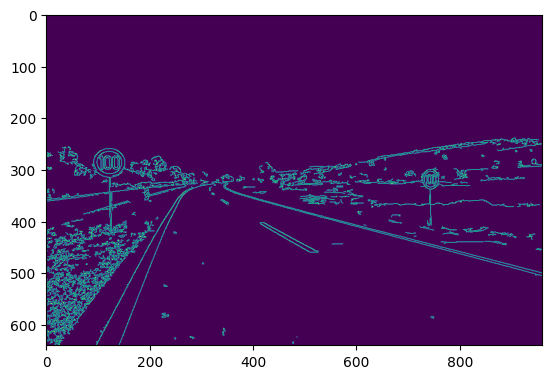

In [18]:
image = cv2.imread('D:\\project_CTV\\road2.jpg', cv2.IMREAD_GRAYSCALE)
if image is None:
    print('Không thể đọc được ảnh!')
    exit()
canny = cv2.Canny(image,threshold1=500,threshold2=200,L2gradient=True,apertureSize=3,)
plt.imshow(image)
plt.show()
plt.imshow(canny)
plt.show()
